In [147]:
import sys
sys.path.append('/Users/isabelcorpus/.pyenv/versions/3.9.0/lib/python3.9/site-packages')
import pandas as pd
import numpy as np 
import matplotlib as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from analysis_helper import *
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In this data_exploration notebook, we: 
- Load data from tsv and vec files
- Note characteristics of dataset using descriptive statistics, such as imbalance in class representation in dataset  
- Visualize entity, sbert embeddings with TSNE 

In [114]:
# Prepare data: 
# load files, normalize embeddings, preprocess for analysis and modeling 
news = pd.read_csv("data/MINDsmall_train/news.tsv", sep='\t', 
                   names = ["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])
news = process_tsv(news, ['title_entities', 'abstract_entities'])

entity_id, entity_vec = load_embeddings('data/MINDsmall_train/entity_embedding.vec')
relation_id, relation_vec = load_embeddings('data/MINDsmall_train/relation_embedding.vec')

entity_vec = normalize(entity_vec)

# extract WikiData Knowledge Graph entity IDs for title and abstract
news['title_entity_ids'] = extract_entity_list(news, 'title_entities', 'WikidataId')
news['abstract_entity_ids'] = extract_entity_list(news, 'abstract_entities', 'WikidataId')

# mean pool entity embeddings to create news embeddings  
news_embeddings = mean_pooled_news_embeddings(entity_vec, entity_id, news, "title_entity_ids")

/Users/isabelcorpus/sample_project/mind/analysis_helper/preprocessing.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col_i].fillna('{}', inplace=True)


In [128]:
# descriptive properties of our datasets 
print(f'news.tsv shape: {news.shape}')
print(f'unique news IDs: {news.news_id.nunique()}')
print(f'news items missing abstract entities: {sum(news.abstract_entities.isnull())}')
print(f'news items missing title: {sum(news.title.isnull())}')

news.tsv shape: (51282, 10)
unique news IDs: 51282
news items missing abstract entities: 0
news items missing title: 0


News in top-2 categories: 59.05%


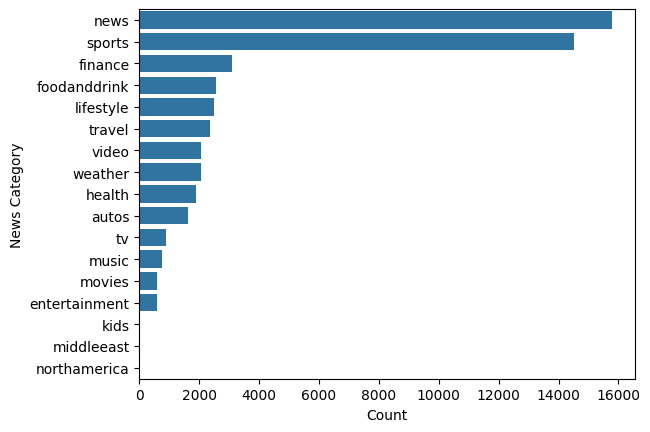

In [149]:
# majority of news is in either news or sports category 
ax = sns.barplot(news.category.value_counts(), orient = 'h')
ax.set(xlabel='Count', ylabel='News Category')
print(f'News in top-2 categories: {round(len(news[news.category.isin(["news", "sports"])])*100/len(news), 2)}%')

In [158]:
# subcategories 
print(f'total subcategories: {news.subcategory.nunique()}')
print(f'{round(100*5420/len(news), 2)}% of news items are relevant to football_nfl subcategory')
news.subcategory.value_counts()[1:10]
# most popular subcategories belong to sports, news, and weather categories.  

total subcategories: 264
10.57% of news items are relevant to football_nfl subcategory


subcategory
football_nfl                5420
newspolitics                2826
newscrime                   2254
weathertopstories           2047
newsworld                   1720
football_ncaa               1665
baseball_mlb                1661
basketball_nba              1555
newsscienceandtechnology    1210
Name: count, dtype: int64

In [116]:
# Generate sentence-bert embeddings using pretrained SBERT model 
# load pre-trained sbert 
sbert = SentenceTransformer('all-MiniLM-L6-v2')
title_embeddings = sbert.encode(np.vstack(news.title))

# join embeddings with news metadata 
title_embedding_df = pd.DataFrame(zip(news.news_id, title_embeddings), columns = ["news_id", "title_embedding"])
news_title_entity = pd.merge(title_embedding_df, news_embeddings, how = "inner", on = "news_id")

<Axes: >

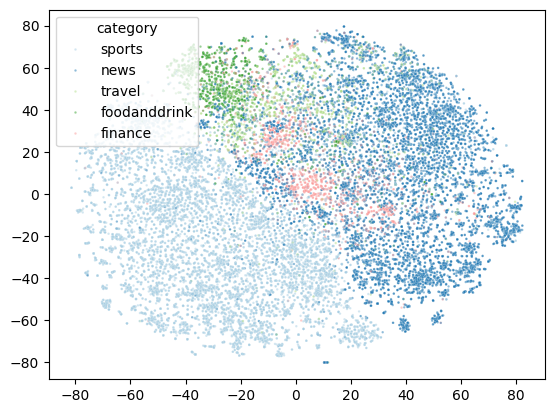

In [126]:
# visualize top 5 categories via tsne of 
top_cat_vecs = news_title_entity[news_title_entity.category.isin(["sports", "news", "finance", "travel", "foodanddrink"])].reset_index()

def prepare_tsne_data(df, x_col, y_col, dim_size):
    X = [x.reshape(dim_size,) for x in df[x_col]]
    y = df[y_col]
    return np.array(X), y

tsne_x, tsne_y = prepare_tsne_data(top_cat_vecs, 'title_embedding', 'category', 384)

# fit + transform TSNE
tsne_X = TSNE(n_components=2, learning_rate=200, init='random', perplexity=15).fit_transform(tsne_x)

sns.scatterplot(
    x = tsne_X[:,0], y = tsne_X[:,1],
    hue = tsne_y, 
    palette = sns.color_palette("Paired", 5),
    legend = "full",
    alpha = 0.5, 
    s = 3
)

<Axes: >

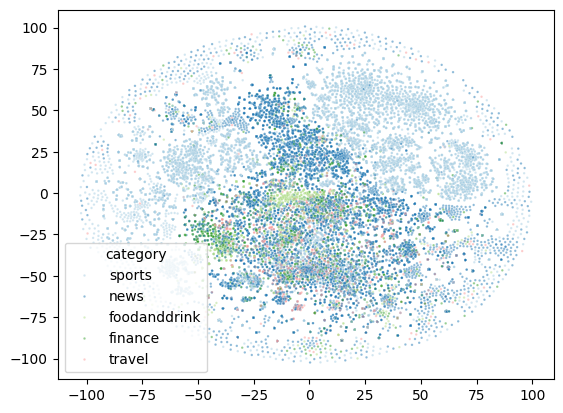

In [125]:
# visualize top 5 categories via tsne - pooled entity embeddings
top_cat_vecs = news_embeddings[news_embeddings.category.isin(["sports", "news", "finance", "travel", "foodanddrink"])].reset_index()
top_cat_vecs = top_cat_vecs.groupby(['news_id', 'category']).entity_vec.apply(lambda x: np.mean(x, axis=0)).reset_index()

tsne_x, tsne_y = prepare_tsne_data(top_cat_vecs, 'entity_vec', 'category', 100)

# fit + transform TSNE
tsne_X = TSNE(n_components=2, learning_rate=200, init='random', perplexity=15).fit_transform(tsne_x)

# tsne visualization - not very useful! may require additional fine tuning to improve clustering, or data 
# may be ill-suited for qualitative understanding of clusters with tsne  
sns.scatterplot(
    x = tsne_X[:,0], y = tsne_X[:,1],
    hue = tsne_y, 
    palette = sns.color_palette("Paired", 5),
    legend = "full",
    alpha = 0.5, 
    s = 3
)